# Pulse ODMR

For this experiment, be sure that your hardware is configured correctly. In particular, when performing after CWODMR, its common to forget to connect the AOM to a pulser. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import logging


In [3]:
import qt3utils.experiments.podmr
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [4]:
logging.basicConfig(level=logging.WARNING)

In [5]:
qt3utils.experiments.podmr.logger.setLevel(logging.INFO)

# Create objects to control the hardware

In [6]:
pulser = qcsapphire.Pulser('COM4')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [7]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Instantiate an experiment object

In [8]:
#from rabi osc experiment
#for rf_power = -25, pi pulse width = 1e-6
experiment = qt3utils.experiments.podmr.PulsedODMR(pulser, rfsynth, nidaq_config, 
                                                   photon_counter_nidaq_terminal = 'PFI0',
                                                   clock_nidaq_terminal = 'PFI12',
                                                   rf_width = 1e-6, rf_power = -25, aom_width = 5e-6)

In [9]:
experiment.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -25,
 'rf_width': 1e-06,
 'aom_width': 5e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 2e-05,
 'rf_pulse_justify': 'center',
 'clock_period': 2e-07}

In [10]:
scan_data = experiment.run(N_cycles=50000)

# scan_data is a list where each element of the list is the result of the CWODMR data acquired at a particular frequency.

# Each element of scan_data contains a list of size two. The first element is the frequency, the second element is 
# an array of data that is the output of the aggregation of the full raw data stream. The size of this array of data
# will be equal to cwodmr.N_clock_ticks_per_cycle

# scan_data - [
#   [2700e6, [d_1, d_2, d_3, ... d_N_clock_ticks_per_cycle]],
#   [2705e6, [d_1, d_2, d_3, ... d_N_clock_ticks_per_cycle]]
#   ...
#   [3000e6, [d_1, d_2, d_3, ... d_N_clock_ticks_per_cycle]]

# ]


INFO:qt3utils.experiments.podmr:RF frequency: 2.8200000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.821 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.822 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.823 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.8240000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.825 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.826 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.827 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.8280000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.829 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.83 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.831 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.8320000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.833 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.834 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.835 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.83600

# Observe the Data

In [11]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)

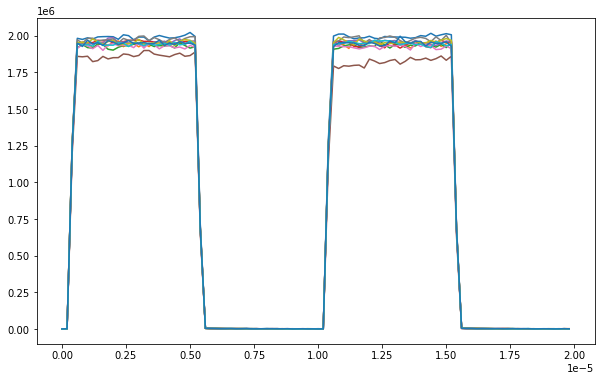

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

for scan in scan_data[::10]:
    
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = scan[0])
    
# for freq in list(combined_scans.keys())[::5]:
#     plot_trace(combined_scans[freq], cwodmr.N_cycles, clock_rate = 1./cwodmr.clock_period)

In [13]:
def get_trace(scan_data, freq = 2870e6):
    frequencies = np.array([x[0] for x  in scan_data ])
    res_index = np.where(np.isclose(frequencies,freq))
    scan = scan_data[int(res_index[0])]
    return scan

In [14]:
def plot_frequency(scan_data,  freq = 2870e6):
    freq, trace = get_trace(scan_data, freq)
    plot_trace(trace, experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = freq)

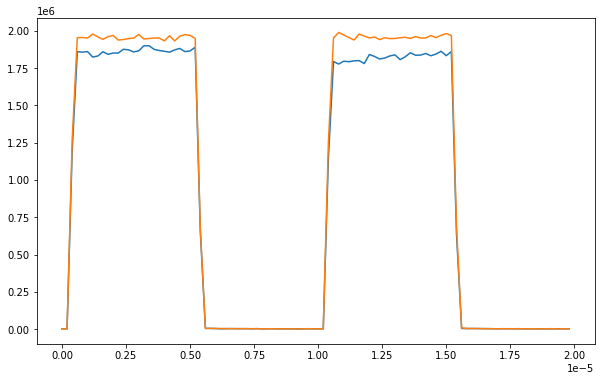

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

# on resonance
plot_frequency(scan_data, 2870e6)

# off resonance
plot_frequency(scan_data, 2900e6)

# Analyze Data

In [16]:
def lockin_amp_like_analysis(trace):
    #the first half is the background, second half is readout after RF pulse
    signal = trace[-len(trace)//2:]
    background = -1*trace[:len(trace)//2]
    return np.sum(signal) + np.sum(background)

def simple_signal_background(trace):
    signal = trace[-len(trace)//2:]
    background = trace[:len(trace)//2]
    return np.sum(signal)/np.sum(background)

In [17]:
freq, trace = get_trace(scan_data, 2870e6)
print(lockin_amp_like_analysis(trace))
print(simple_signal_background(trace))

-10637.0
0.9771927605186251


In [18]:
freq, trace = get_trace(scan_data, 2.911e9 )
print(lockin_amp_like_analysis(trace))
print(simple_signal_background(trace))

96.0
1.0001970669863531


In [19]:
# or, you can define a function that specifically integrates over the time-periods of the trace
# where there is laser light on the sample. However, this is a bit trickier and you must
# be sure your function matches the data precisely 


def signal_to_background(trace, pre_trigger, experiment, duty = 1.0):
    signal = trace[-len(trace)//2:]
    background = trace[:len(trace)//2]
    
    signal = signal[pre_trigger:]
    background = background[pre_trigger:]
    
    aom_width = int(duty * experiment.aom_width/experiment.clock_period)
    return np.sum(signal[:aom_width])/np.sum(background[:aom_width])

# Plot Contrast

In [20]:
contrast = [(m[0], lockin_amp_like_analysis(m[1])) for m in scan_data]

In [21]:
contrast = np.array(contrast)

Text(0.5, 0, 'frequency [Hz]')

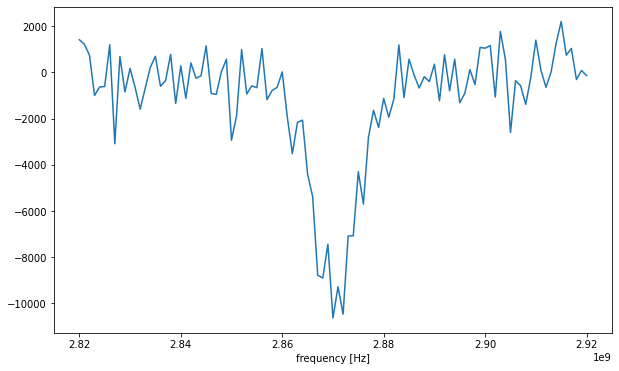

In [22]:
x_data = contrast[:, 0]
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, '-', label='Data')

plt.xlabel('frequency [Hz]')


In [23]:
contrast = [(m[0], simple_signal_background(m[1])) for m in scan_data]
contrast = np.array(contrast)

Text(0.5, 0, 'frequency [Hz]')

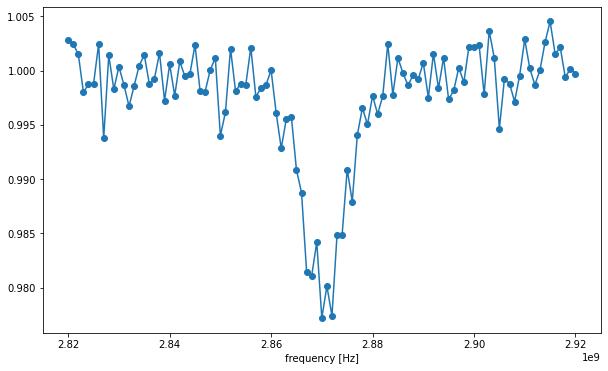

In [24]:
x_data = contrast[:, 0]
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('frequency [Hz]')


Text(0.5, 0, 'frequency [Hz]')

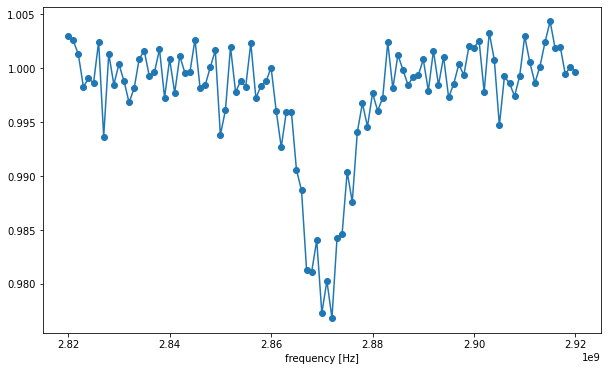

In [25]:
contrast = [(m[0], signal_to_background(m[1], 2, experiment)) for m in scan_data]
contrast = np.array(contrast)

x_data = contrast[:, 0]
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('frequency [Hz]')


Text(0.5, 0, 'frequency [Hz]')

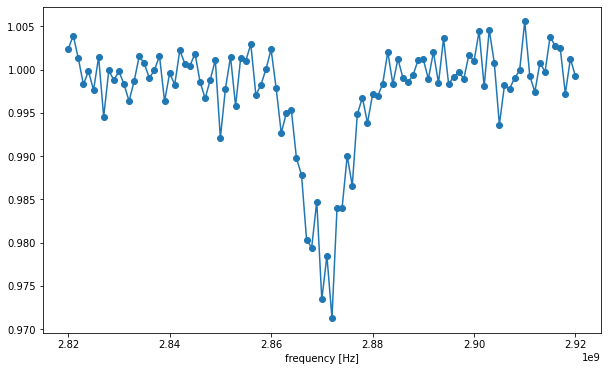

In [26]:
contrast = [(m[0], signal_to_background(m[1], 2, experiment, 0.75)) for m in scan_data]
contrast = np.array(contrast)

x_data = contrast[:, 0]
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('frequency [Hz]')

## Change some parameters if you wish

In [27]:
experiment.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -25,
 'rf_width': 1e-06,
 'aom_width': 5e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 2e-05,
 'rf_pulse_justify': 'center',
 'clock_period': 2e-07}

In [28]:
experiment.rf_power = 0
experiment.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': 0,
 'rf_width': 1e-06,
 'aom_width': 5e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 2e-05,
 'rf_pulse_justify': 'center',
 'clock_period': 2e-07}

In [29]:
qt3utils.experiments.podmr.logger.setLevel(logging.WARNING) #silence the logging since we know its working

In [30]:
scan_data = experiment.run(N_cycles=10000)

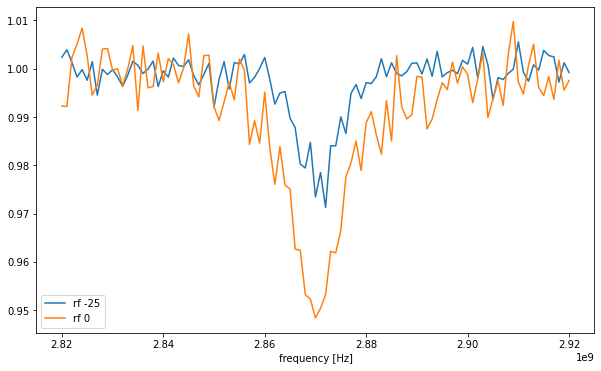

In [31]:
contrast_rfm0 = [(m[0], signal_to_background(m[1], 2, experiment)) for m in scan_data]
contrast_rfm0 = np.array(contrast_rfm0)


plt.figure(figsize=(10, 6))
plt.plot(contrast[:, 0], contrast[:, 1], '-', label='rf -25')
plt.plot(contrast_rfm0[:, 0], contrast_rfm0[:, 1], '-', label='rf 0')

plt.xlabel('frequency [Hz]')
plt.legend()


In [32]:
rf_powers = [-25, -20, -15, -10, -5]
scans = {}
contrasts = {}
for rfp in rf_powers:
    print(f'power: {rfp} db mW')
    experiment.rf_power = rfp
    scans[rfp] = experiment.run(N_cycles=50000)
    contrasts[rfp] = np.array([(m[0], signal_to_background(m[1], 2, experiment)) for m in scans[rfp]])


power: -25 db mW
power: -20 db mW
power: -15 db mW
power: -10 db mW
power: -5 db mW


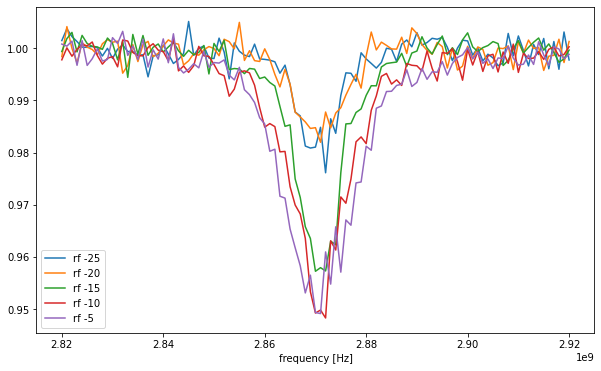

In [33]:
plt.figure(figsize=(10, 6))

for rfp, contrast in contrasts.items():
    plt.plot(contrast[:, 0], contrast[:, 1], '-', label=f'rf {rfp}')

plt.xlabel('frequency [Hz]')
plt.legend()
